## Neuroevolution of CNN architectures

### Must Remember Points:
**Output dimension = W-F+2P/S + 1 is needed to calculate the input to the Linear layer**  
**If the output size ends up with a decimal ending it is floored to the nearest integer (13.5 --> 13)**  
**CONV --> RELU --> Dropout is the normally followed configuration**  
**Dense --> RELU --> Dropout is the norm**  
**Subset and sampler are to ways to effectively split data**  
**When taking model to production check for weight initializers in the pytorch resnet implementation Github**


## Loading the Dataset 

In [3]:
import torch 
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from skorch import 

In [4]:
num_workers = 0

batch_size = 50

transform = transforms.ToTensor()

In [214]:
# #Splitting into only train and test datasets
# train_dataset = datasets.MNIST(root='data',train=True,download=True,transform=transform)
# test_dataset = datasets.MNIST(root='data',train=False,download=True,transform=transform)

# trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers)
# testloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers)

In [ ]:
# #Alternate method for creating trainloader with stratified sampling
# train_subset = torch.utils.data.Subset(train_dataset,train_idx)
# train_loader = torch.utils.data.DataLoader(tr,batch_size=batch_size)

In [246]:
train_dataset = datasets.MNIST(root='data',train=True,download=False,transform=transform)
test_dataset = datasets.MNIST(root='data',train=False,download=False,transform=transform)

In [247]:
targets = train_dataset.targets

train_idx, valid_idx= model_selection.train_test_split(np.arange(len(targets)),test_size=0.25,shuffle=True,stratify=targets)

In [248]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,num_workers=num_workers)

In [243]:
# #Counting the train loader label instances per batch
# images,labels = next(iter(train_loader))
# set(labels.numpy())
# print([list(labels.numpy()).count(i) for i in set(labels.numpy()) ])
# labels

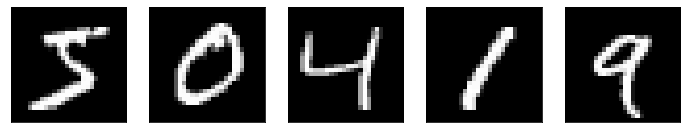

In [249]:
fig = plt.figure(figsize=(12,4))
for i in range(5):
    a = train_dataset[i]
    img = np.squeeze(a[0]) 
    ax = plt.subplot(1,5, i+1,xticks=[],yticks=[])
    ax.imshow(img, cmap='gray')

In [252]:
tr_images, tr_labels= next(iter(train_loader))
val_images, val_labels = next(iter(valid_loader))
te_images, te_labels= next(iter(test_loader))

print("Train loader batch - " + str(list(tr_images.shape)))
print("Train loader batches - " + str(len(train_loader)))
print("Validation loader batch - "+ str(list(val_images.shape)))
print("Validation loader batches - "+ str(len(valid_loader)))
print("Test loader batch - " + str(list(te_images.shape)))
print("Test loader batches - " + str(len(test_loader)))

Train loader batch - [50, 1, 28, 28]
Train loader batches - 900
Validation loader batch - [50, 1, 28, 28]
Validation loader batches - 300
Test loader batch - [50, 1, 28, 28]
Test loader batches - 200


## Defining the training routine

In [258]:
def train(model,optimizer,loss_fun,trainloader,validloader,epochs=10,device="cuda"):
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    model.to(device)
    
    tr_list = []
    val_list = []
    acc_list = []
    epoch_list = [i+1 for i in range(epochs)]
    
    for epoch in range(epochs):
        
        training_loss = 0
        validation_loss = 0
        model.train()                #--------------------->Allows for parameters to be updated by backpropagation
        
        for batch in trainloader:
            
            optimizer.zero_grad()
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
        
        model.eval()              #------------------------>Freezes the parameters for model validation
        correct_pred = 0
        total_pred = 0
        
        for batch in testloader:
            
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            
            validation_loss +=loss.item()
            
            ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
            correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
            
            correct_pred += torch.sum(correct).item()
            total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]
            
        training_loss = training_loss/len(trainloader)
        validation_loss = validation_loss/len(testloader)
        
        tr_list.append(training_loss)
        val_list.append(validation_loss)
        acc_list.append((correct_pred*100.0/total_pred))
            
        print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}"
              .format(epoch+1, training_loss,validation_loss, correct_pred * 100.0 / total_pred))
    
    fig = plt.figure(figsize=(20,6))
        
    plt.subplot(1,3,1)
    plt.plot(epoch_list,tr_list)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,2)
    plt.plot(epoch_list,val_list)
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,3)
    plt.plot(epoch_list,acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    
    plt.show()

In [263]:
def test(model,testloader,device="cuda"):
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    model.to(device)
    
    acc_list = []
        
    model.eval()              #------------------------>Freezes the parameters for model validation
    correct_pred = 0
    total_pred = 0
        
    for batch in testloader:
            
        inputs,labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
            
        ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
        correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
        
        correct_pred += torch.sum(correct).item()
        total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]
        
        acc_list.append((correct_pred*100.0/total_pred))
            
    print("Test set accuracy: " + str(sum(acc_list)/len(acc_list)))

## 1)Vanilla CNN

In [255]:
class Vanilla_CNN_Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
                                                    #------------>Input size = 28x28x1
        self.conv1 = nn.Conv2d(1,16,3,padding=1)    #------------>Output size = 28x28x16 (If continuous convolution 
        self.conv2 = nn.Conv2d(16,32,3,padding=1)   #------------>Output size = 28x28x32  operations without pooling
        #self.conv3 = nn.Conv2d(32,64,3,padding=1)   #------------>Output size = 28x28x64  then this would be the output size)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(7*7*32,500)            #------------>Input size = 7x7x32  
        self.output = nn.Linear(500,10)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self,x):
        
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        x = x.view(-1,7*7*32)
        
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.log_softmax(self.output(x),dim=1)
            
        return x

In [256]:
vanilla_cnn = Vanilla_CNN_Model()
vanilla_cnn_optimizer = torch.optim.Adam(vanilla_cnn.parameters(),lr=0.03,)
vanilla_cnn_criterion = nn.NLLLoss()

Epoch: 1, Training Loss: 0.54, Validation Loss: 0.26, accuracy = 91.97
Epoch: 2, Training Loss: 0.38, Validation Loss: 0.25, accuracy = 92.09
Epoch: 3, Training Loss: 0.37, Validation Loss: 0.26, accuracy = 92.83
Epoch: 4, Training Loss: 0.37, Validation Loss: 0.29, accuracy = 91.32
Epoch: 5, Training Loss: 0.36, Validation Loss: 0.25, accuracy = 92.73
Epoch: 6, Training Loss: 0.37, Validation Loss: 0.28, accuracy = 91.97
Epoch: 7, Training Loss: 0.37, Validation Loss: 0.31, accuracy = 91.57
Epoch: 8, Training Loss: 0.37, Validation Loss: 0.25, accuracy = 92.89
Epoch: 9, Training Loss: 0.38, Validation Loss: 0.26, accuracy = 92.13
Epoch: 10, Training Loss: 0.38, Validation Loss: 0.26, accuracy = 92.83


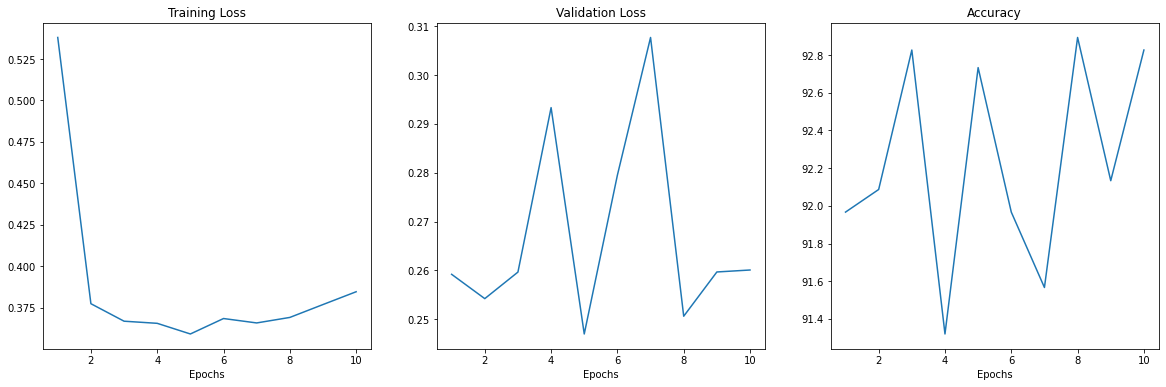

In [257]:
train(vanilla_cnn,vanilla_cnn_optimizer,vanilla_cnn_criterion,train_loader,valid_loader)

In [264]:
test(vanilla_cnn,test_loader)

Test set accuracy: 91.76731235290255


## 2)Neuroevolution for Vanilla CNN

Will be using the block encoding technique with predefined parameters  
**If padding P = F-1/2 then input and output size is the same, we will be using this so that output dimension reduces only 
due to the pooling operation and not during the convolution stages**

### Network Architecture

In [376]:
import random
import math

In [277]:
N = 50
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_test = X_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

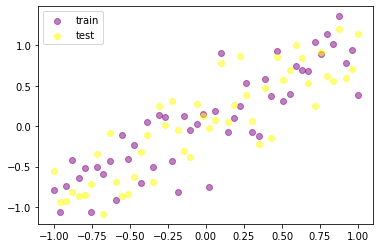

In [278]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [287]:
N_h = 100

model_dropout = nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

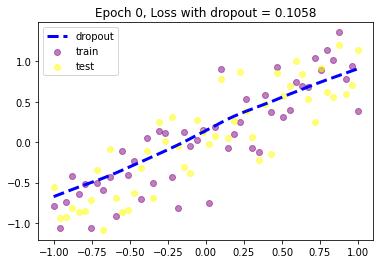

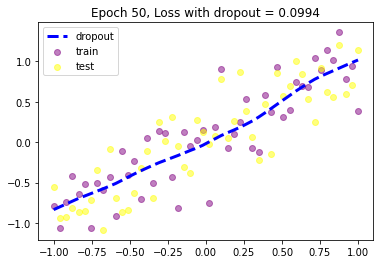

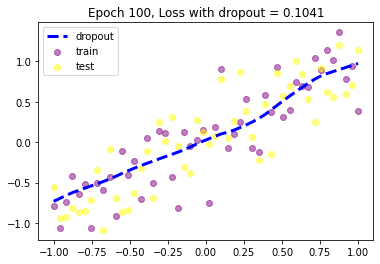

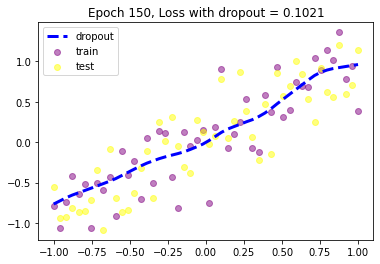

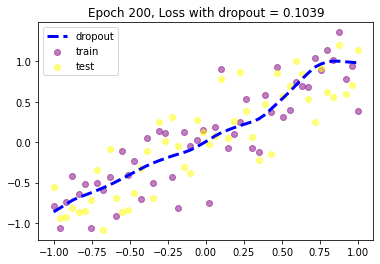

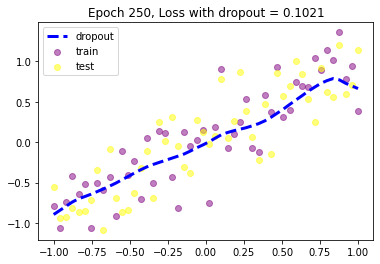

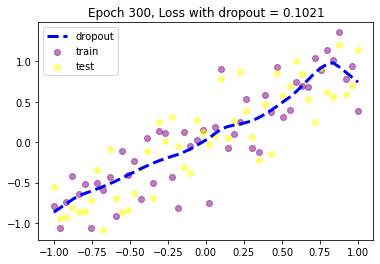

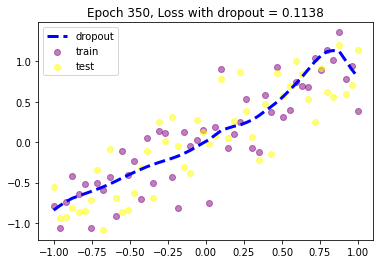

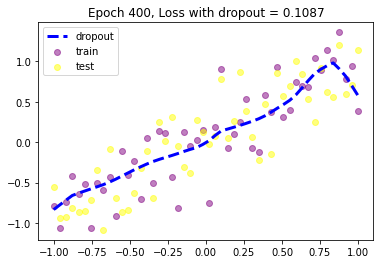

In [284]:
max_epochs = 401

for epoch in range(max_epochs):
    
    # look at the entire data in a single shot
       
    pred_dropout = model_dropout(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()
    
    
    if epoch % 50 == 0:
        
        model_dropout.eval()
        
        test_pred_dropout = model_dropout(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)
        
        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss with dropout = %0.4f' % (epoch, test_loss_dropout))
        
        plt.legend()

        model_dropout.train()
        
        plt.pause(0.05)

In [577]:
# l = [i for i in range(16)]
# for i in range(0,len(l)-2,7):
#     print(i)

# class Mod(nn.Module):
     
#     def __init__(self):
        
#         super().__init__()
        
#         #self.seq = nn.Sequential(nn.Linear(1,1))
        
#         self.
        
#         self.model_dropout = nn.Sequential(
#     torch.nn.Linear(2, N_h),
#     torch.nn.Dropout(0.2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(N_h, N_h),
#     torch.nn.Dropout(0.2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(N_h, 1))
        
#         #self.seq.add_module("Add-on",self.model_dropout)
        
#         self.add_module("Add-on",self.model_dropout)
        
        
#     def forward(self,x):
        
#         x = self.Mod(x)
        
#         return x

# model = Mod()
# model

In [522]:
def convert_cnn_block_parameters(param_list):
    
    """Converts the conv block parameters not the optimizer and learning rate from the chromosome"""
    
    #Parameters = [Block act, No of conv, No. of filters, Filter size, Dropout, Pooling, Activation fn.]
    
    num_of_filters     = [8,16,32,64]
    filter_sizes       = [3,5,7]
    pooling_strategies = ['MaxPool2d','AvgPool2d']
    activation_funs    = ['ReLU','Tanh','LeakyReLU']

    conv_layers  =  round(param_list[1])
    num_filters  =  num_of_filters[math.floor(param_list[2])]
    filter_dim   =  filter_sizes[math.floor(param_list[3])]
    dropout_prob =  param_list[4]
    pooling      =  pooling_strategies[round(param_list[5])]
    activation   =  activation_funs[math.floor(param_list[6])]
    
    return conv_layers, num_filters, filter_dim, dropout_prob, pooling, activation

In [672]:
class Neuro_Vanilla_CNN_Model(nn.Module):
    
    def __init__(self,network_params,input_size,input_channels):
        
        super().__init__()
        
        self.input_size       = input_size         #----->Fixed instance variable 

        self.input_channels   = input_channels     #----->Fixed instance variable
        
        self.conv_blocks      = nn.Sequential()
        
        self.current_size     = input_size         #------>Instance variable changes with each conv block 
        
        self.current_channels = input_channels     #------>Instance variable changes with each conv block
        
        for block_idx in range(0,len(network_params)-2,7):  #----->Accesses 1st indice of each conv block (Excluding last 2 parameters) 
            
            if round(network_params[block_idx])==1:
                
                self.conv_blocks.add_module("Conv_Block " + str(block_idx//7 + 1),
                                            self.create_conv_block(network_params[block_idx:block_idx+7]))
    
        self.fc1 = nn.Linear(self.current_size*self.current_size*self.current_channels,400)      
        
        self.output = nn.Linear(400,10)
        
        self.dropout = nn.Dropout(0.3)
    
    def create_conv_block(self,params):
        
        #Parameters = [Block act, No of conv, No. of filters, Filter size, Dropout, Pooling, Activation fn.]
        #Number of filters and filter size is same for both convolutional layers if present
        
        num_conv_layer, num_filters, filter_size, dropout_prob, pooling_strategy, activation_fn = convert_cnn_block_parameters(params)               
        
        cnn_block    = nn.Sequential()
        
        padding_size = (filter_size - 1) // 2       #----->Calculated so that input size equal to ouptut size
    
        for layers in range(1,num_conv_layer+1):
            
            cnn_block.add_module("Conv_layer" + str(layers),nn.Conv2d(in_channels=self.current_channels,out_channels=num_filters,
                                                                      kernel_size=filter_size,stride=1,padding=padding_size))
            
            self.current_channels = num_filters
            
            cnn_block.add_module("Activation" + str(layers),nn.__getattribute__(activation_fn)())
            
        cnn_block.add_module("Dropout",nn.Dropout2d(p=dropout_prob))
        
        cnn_block.add_module("Pooling",nn.__getattribute__(pooling_strategy)(2,2))
        
        self.current_size //= 2 
        
        return cnn_block
    
    def forward(self,x):

        x = self.conv_blocks(x)
        
        x = x.view(-1,self.current_size*self.current_size*self.current_channels)
        
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.log_softmax(self.output(x),dim=1)
            
        return x

In [ ]:
def get_accuracy(params_list):
    
    """The function takes the input of the floating number encoded chromosome and returns the accuracy as thr output"""
    
    layer1, layer2, activation1, activation2, learning_rate, optimizer = convert_params(params_list)
    
    classifier = NN_Model(layer1, layer2, activation1, activation2)
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    classifier.to(device)

    loss_function = nn.NLLLoss()
    
    opt = torch.optim.__getattribute__(optimizer)
    
    optimizer = opt(classifier.parameters(),lr=learning_rate)
    
    accuracy = train(classifier,optimizer,loss_function,trainer,tester,epochs=10)
    
    #return max(accuracy)
    return sum(accuracy)/len(accuracy)

### Genetic Representation and Solution

In [578]:
from deap import tools
from deap import base
from deap import creator
import random
import elitism
import numpy as np
import seaborn as sns

In [659]:
BOUNDS_LOW  = [0 , 1 , 0 , 0 , 0   , 0 , 0]
BOUNDS_HIGH = [1 , 2 , 4 , 3 , 0.5 , 1 , 3]

In [660]:
NUM_OF_CNN_PARAMS = 7
NUM_OF_BLOCKS     = 2
POPULATION_SIZE   = 20
P_CROSSOVER       = 0.9
P_MUTATION        = 0.2
MAX_GENERATIONS   = 8
HALL_OF_FAME_SIZE = 3
CROWDING_FACTOR   = 10.0
NUM_OF_PARAMS     = NUM_OF_BLOCKS*NUM_OF_CNN_PARAMS + 2 

In [662]:
creator.create("FitnessMax",base.Fitness,weights=(1.0,))
creator.create("Individual",list,fitness=creator.FitnessMax)

In [663]:
toolbox = base.Toolbox()
for i in range(NUM_OF_CNN_PARAMS):
    toolbox.register("attribute_"+str(i),random.uniform,BOUNDS_LOW[i],BOUNDS_HIGH[i])

In [664]:
attributes = ()
for i in range(NUM_OF_CNN_PARAMS):
    attributes += (toolbox.__getattribute__("attribute_"+str(i)),)

In [665]:
toolbox.register("individualCreator",tools.initCycle,creator.Individual,attributes,n=NUM_OF_BLOCKS)
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

In [687]:
sample = toolbox.individualCreator()
sample

[0.8504779953119377,
 1.001098860157787,
 3.5176086497641905,
 2.791262305058235,
 0.06219654309116612,
 0.36324583938677224,
 0.023338170346963283,
 0.09487140992252951,
 1.035396148833186,
 1.8222135431738495,
 2.2605160432098264,
 0.16648093011209192,
 0.5315783752884528,
 2.2341701569410573]

In [688]:
mod = Neuro_Vanilla_CNN_Model(sample,28,1)
mod

Neuro_Vanilla_CNN_Model(
  (conv_blocks): Sequential(
    (Conv_Block 1): Sequential(
      (Conv_layer1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (Activation1): ReLU()
      (Dropout): Dropout2d(p=0.06219654309116612, inplace=False)
      (Pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc1): Linear(in_features=12544, out_features=400, bias=True)
  (output): Linear(in_features=400, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [690]:
mod_optimizer = torch.optim.Adam(mod.parameters(),lr=0.03,)
mod_criterion = nn.NLLLoss()

Epoch: 1, Training Loss: 0.88, Validation Loss: 0.22, accuracy = 93.33
Epoch: 2, Training Loss: 0.46, Validation Loss: 0.26, accuracy = 93.02
Epoch: 3, Training Loss: 0.45, Validation Loss: 0.23, accuracy = 93.99
Epoch: 4, Training Loss: 0.45, Validation Loss: 0.24, accuracy = 93.43


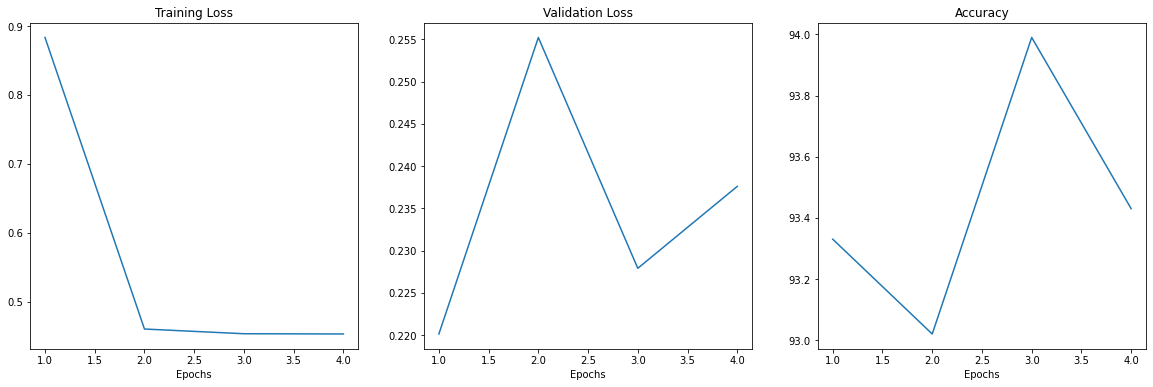

In [691]:
train(mod,mod_optimizer,mod_criterion,train_loader,valid_loader,epochs=4)